# Hydrological Data Colection Center
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 27-03-2025<br>

**Introduction:**<br>
This code downloads the stations and time series available in the HYDRO data base.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point, box
import re
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml
import unicodedata

In [2]:
from efashydro.stations import get_stations, find_duplicates
from efashydro.timeseries import get_timeseries
from lisfloodreservoirs.utils import DatasetConfig, APIConfig

In [ ]:
# def remove_accents(text):
#     return ''.join(
#         c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn'
#     )

## Configuration

In [3]:
# station filters
TYPE = 'reservoir'
COUNTRY_ID = 'ES' # 'HR'
PROVIDER_ID = None

# # dataset cofiguration
# cfg = DatasetConfig(f'./ResOps{COUNTRY_ID}/config_dataset.yml')

# HDMS API configuration
api = APIConfig('./HDMS_API.yml')

# study period
START = datetime(1979, 1, 1)
END = datetime.now().date()


# variables of interest
VARIABLES = {
    'river': {
        # 'W': 'water_level',
        'D': 'discharge',
    },
    'reservoir': {
        'I': 'inflow',
        'O': 'outflow',
        'V': 'volume',
        'R': 'level',
    }
}

# directory of the HDMS dataset
PATH_HDMS = Path(f'Z:/nahaUsers/casadje/datasets/hDMS/{TYPE}')

## Stations

In [4]:
stations = get_stations(
    api.USERNAME,
    api.PASSWORD,
    kind=TYPE,
    country_id=COUNTRY_ID,
    provider_id=PROVIDER_ID,
)
print(f'Metadata for {len(stations)} stations were extracted')

Metadata for 512 stations were extracted


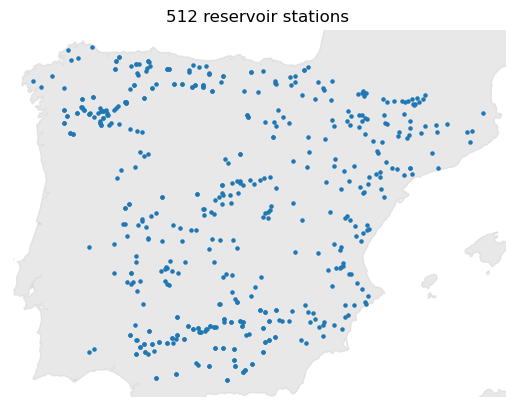

In [5]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
stations.plot(markersize=5, ax=ax)
ax.set_title(f'{len(stations)} {TYPE} stations')
# ax.set_extent([-10, 5, 35.5, 45])
ax.axis('off');

In [ ]:
# export
PATH_GIS = PATH_HDMS / 'GIS'
PATH_GIS.mkdir(parents=True, exist_ok=True)
if PROVIDER_ID:
    shp_file = PATH_GIS / '{0}_HDMS_{1}_{2}.shp'.format(TYPE, PROVIDER_ID, datetime.now().strftime('%Y%m%d'))
elif COUNTRY_ID:
    shp_file = PATH_GIS / '{0}_HDMS_{1}_{2}.shp'.format(TYPE, COUNTRY_ID, datetime.now().strftime('%Y%m%d'))
else:
    shp_file = PATH_GIS / '{0}_HDMS_{1}.shp'.format(TYPE, datetime.now().strftime('%Y%m%d'))
stations.to_file(shp_file)
print(f'Shapefile of stations saved in {shp_file}')

**Duplicated by distance**

In [6]:
# find duplicates based on distance and provider
duplicates = find_duplicates(stations, provider_col='PROV_ID', distance_thr=.01667)
print(f'{len(duplicates)} duplicates were found')

e:\casadje\github\efas_hydro\src\efashydro\stations.py:211: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distance = others.geometry.distance(point)


99 were found


In [ ]:
# export
with open(f"duplicated_{TYPE}.txt", "w") as file:
    for sublist in duplicates:
        file.write(','.join(map(str, sublist)) + '\n')

**Duplicated reservoir names**

In [ ]:
# mapping local and English river names
# river_loc_en = {}
# for river_loc in reservoirs.RIVER_LOC.unique():
#     if river_loc == '':
#         continue
#     mask = reservoirs.RIVER_LOC == river_loc
#     river_en = reservoirs[mask].RIVER_EN.unique().tolist()
#     if '' in river_en:
#         river_en.remove('')
#     if len(river_en) == 0:
#         print(f'No correspondece for river {river_loc}')
#     elif len(river_en) == 1:
#         river_loc_en[river_loc] = river_en[0]
#     else:
#         print(river_loc, river_en)

# # fill in the English river names
# for river_loc, river_en in river_loc_en.items():
#     mask = reservoirs.RIVER_LOC == river_loc
#     reservoirs.loc[mask, 'RIVER_EN'] = river_en

In [ ]:
# find duplicates
res_name_counts = reservoirs.RES_NAME.value_counts()
duplicated_res_name = res_name_counts[res_name_counts > 1].index.tolist()
print(f'{len(duplicated_res_name)} reservoir names are duplicated')

# dictionary that connects duplicated local IDs and EFAS IDs
duplicate_names = {}
for res_name in duplicated_res_name:
    duplicate_names[res_name] = reservoirs.loc[reservoirs.RES_NAME == res_name].index.tolist()

# export
with open('duplicated_res_name.yml', 'w') as file:
    yaml.dump(duplicate_names, file, default_flow_style=False)

In [ ]:
# # summarize data availability
# data_cols = reservoirs.columns[hdcc.columns.str.contains('[O|V|R]_Has_')].tolist()
# reservoirs[data_cols].astype(bool).sum()

***

In [ ]:
reservoirs.COUNTRY_ID.value_counts()

In [ ]:
reservoirs.COUNTRY.value_counts()

In [ ]:
for country in reservoirs.COUNTRY_ID.unique():
    mask = reservoirs.COUNTRY_ID == country
    break

In [ ]:
reservoirs_es = reservoirs[reservoirs.COUNTRY_ID == 'ES']


**Duplicated local ID**

In [ ]:
# find duplicates
local_id_counts = reservoirs_es.LOCAL_ID.value_counts()
duplicated_local_id = local_id_counts[local_id_counts > 1].index.tolist()
print(f'{len(duplicated_local_id)} local IDs are duplicated')

# dictionary that connects duplicated local IDs and EFAS IDs
duplicates_id = {}
for local_id in duplicated_local_id:
    duplicates_id[local_id] = reservoirs_es.loc[reservoirs.LOCAL_ID == local_id].index.tolist()

with open('duplicated_local_id.yml', 'w') as file:
    yaml.dump(duplicates_id, file, default_flow_style=False)

**Duplicated by name**

In [ ]:
reservoirs[mask

In [ ]:
reservoirs.columns

In [ ]:
reservoirs.PROV_ID.value_counts()

***

## Timeseries

In [ ]:
# load stations in Guadiana
stations = gpd.read_file('Z:/nahaUsers/casadje/datasets/hDMS/river/GIS/river_HDMS_20250314.shp').set_index('EFAS_ID', drop=True)
stations = stations[stations.BASIN_EN == 'guadiana']

print(f'{len(stations)} gauging stations')

In [ ]:
PATH_AFR = Path('Z:/nahaUsers/casadje/GloFASv5/stations/Africa/')

In [ ]:
efas_ids = sorted([int(file.stem) for file in (PATH_AFR / 'ncextract' / 'dis24').glob('*.nc')])

In [ ]:
stations = stations.loc[efas_ids]

### Data range

```Python
service = 'hdatarange'
url = f'{api.URL}/{service}/'
response = requests.get(url + '9142', auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))

if response.status_code == 200:
    data = response.json()
    # Do something with the data
else:
    print("Failed to retrieve data from the API")
```

### Operational

In [ ]:
PATH_HDMS = PATH_AFR / 'discharge' / 'hDMS'

In [ ]:
# data must be downloaded in 4 batches due to server limitations
dates = [date.date() for date in pd.date_range(START, END, periods=4)]

services = {
    # 'NRT': 'noperational24h', # 24 hours NRT operational data
    'HIST': 'nhoperational24hw', # 24 hours historic weighted operational table
}

for name, service in services.items():
    
    # path where the data will be saved
    path_out = PATH_HDMS / service
    path_out.mkdir(parents=True, exist_ok=True)

    pbar = tqdm(stations.index, desc='station', total=stations.shape[0])
    for ID in pbar:

        file_out = path_out / f'{ID}.nc'
        if file_out.exists():
            continue

        # download data
        data = {}
        for var, variable in VARIABLES[TYPE].items(): # for each variable
            if 'serie' in locals():
                del serie
            serie = pd.DataFrame(columns=[ID], dtype=float)
            for i, (st, en) in enumerate(zip(dates[:-1], dates[1:])): # for each batch
                if i > 0:
                    st += timedelta(days=1)           
                url = f'{api.URL}/{service}/{st.strftime(strftime)}/{en.strftime(strftime)}/{ID}/{var}' #'/'
                response = requests.get(url, auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))

                if response.status_code == 200:
                    if 'message' in response.json():
                        continue
                    serie_i = pd.DataFrame(response.json())
                    if serie_i.shape[0] > 0:
                        serie_i = serie_i[['Timestamp', 'AvgValue']].set_index('Timestamp', drop=True)
                        serie_i.index = pd.to_datetime(serie_i.index)
                        serie_i.columns = [ID]
                        serie = pd.concat((serie, serie_i), axis=0)
            if serie.shape[0] > 0:
                data[variable] = serie.sort_index().copy()

        if len(data) > 0:
            
            # convert to xarray.Dataset
            data = xr.Dataset({var: xr.DataArray(serie, dims=['date', 'ID']) for var, serie in data.items()})

            # export as NetCDF
            data.to_netcdf(file_out)
            print(f'Saved {file_out}')
        else:
            print(f'No data was found for station with EFAS_ID {ID}')

In [ ]:
from typing import Union, Optional, List
import logging

def get_timeseries(
    user: str,
    password: str,
    station_id: int,
    service: str,
    variable: Union[str, List[str]],
    start: Optional[datetime] = None,
    end: Optional[datetime] = None,
):
    """It extracts time series from the hydrological data base based on the specified filters.
    Refer to the documentation (https://confluence.smhi.tds.tieto.com/pages/viewpage.action?spaceKey=EHDCC&title=D2-07.2.+API) for further reference about services and variables.
    
    Parameters:
    -----------
    user: string
    password: string
    station_id: int
        Station identifier in the database
    service: string
        Type of data to be extracted. Possible values:
            Near-real-time data: 'noperational1h', 'noperational6h', 'noperational24h'
            Historical data: 'nhoperational1h', 'nhoperational6h', 'nhoperational24h'
    variable: string or list of strings
        Abbreviations of the variables of interest. Possible values: 
            'W': river stage
            'D': river discharge
            'I': reservoir inflow
            'O': reservoir outflow
            'V': reservoir storage
            'R': reservoir level
    start: datetime (optional)
        Beginning of the period of interest. If not provided, 1950-01-01 will be used as the lower limit.
    end: datetime (optional)
        End of the period of interest. If not provided, the current time will be used as the upper limit.
        
    Returns:
    --------
    data: pandas.DataFrame
        The time series for that station, service and variables.
    """
    
    API_URL = 'https://ehdcc.soologic.com/wsOperational/webapi'
    VARIABLES = {
        'W': 'water_level',
        'D': 'discharge',
        'I': 'inflow',
        'O': 'outflow',
        'V': 'volume',
        'R': 'level',
    }
    SERVICES = {
        'noperational1h': '1 hour near-real-time operational data', 
        'noperational6h': '6 hour near-real-time operational data', 
        'noperational24h': '24 hour near-real-time operational data', 
        'nhoperational1h': '1 hour historical operational data', 
        'nhoperational6h': '6 hour historical operational data', 
        'nhoperational24hw': '24 hour historical operational data', 
        # 'nrt': 'Near-real-time data. Output in the same format that was being originally used in FTP files', 
        # 'historic': 'Historic data. Output in the same format that was being originally used in FTP files'
    }
    strftime = '%Y-%m-%dT%H:%M:%S'
    
    if service not in SERVICES:
        logging.error(f'Service {service} is not correct. Choose one of these: {list(SERVICES)}')
        return None
    
    if isinstance(variable, str):
        variable = [variable]
        
    # time resolution of the service
    time_resolution = int(re.findall(r'\d+', service)[0]) # hours
    
    # data must be downloaded in batches due to server limitations
    start = start or datetime(1950, 1, 1)
    end = end or datetime.now()
    batch_dates = pd.date_range(start, end, periods=11).date

    # download data
    data_list = []
    for var in tqdm(variable, desc='Variables'):

        if var not in VARIABLES:
            logging.warning(f'Variable {var} is not a correct variable abbreviation.')
            continue
            
        var_name = VARIABLES[var]
        serie_list = []
        for i, (st, en) in enumerate(zip(dates[:-1], dates[1:])):
            if i > 0:
                st += timedelta(hours=time_resolution)     
                
            # request data
            url = f'{API_URL}/{service}/{st.strftime(strftime)}/{en.strftime(strftime)}/{station_id}/{var}'
            response = requests.get(url, auth=requests.auth.HTTPBasicAuth(user, password))
            
            # process response
            if response.ok:
                if 'message' in response.json():
                    logging.info(response.json())
                    continue
                df = pd.DataFrame(response.json())
                if not df.empty:
                    df = df[['Timestamp', 'AvgValue']].rename(columns={'AvgValue': var_name})
                    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
                    df.set_index('Timestamp', inplace=True)
                    serie_list.append(df)

        if serie_list:
            data_list.append(pd.concat(serie_list, axis=0).sort_index())

    # combine all data
    if data_list:  
        data = pd.concat(data_list, axis=1)
        
        # ensure a complete index with the expected resolution
        idx = pd.date_range(data.first_valid_index(), data.last_valid_index(), freq=f'{time_resolution}h')
        if len(idx) > len(data):
            data = data.reindex(idx)
        data.index.name = 'time'
        return data
    
    logging.info(f'No data was found for station with EFAS_ID {station_id}')
    return None

In [ ]:
user = api.USERNAME
password = api.PASSWORD
station_id = 9142
service = 'nhoperational24hw'
variable = ['V', 'O']
start = datetime(2010, 10, 1)
end = datetime(2020, 9, 30)

In [ ]:
ts = get_timeseries(api.USERNAME, api.PASSWORD, 9142, 'nhoperational24hw', ['R', 'V', 'O'])

In [ ]:
ts

In [ ]:
datetime(1950, 1, 1)

In [ ]:
datetime.now().date()